# This notebook is to explore the possibility of using fast embedding method to embed the whole Kapoor network

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
import os
from sys import platform 
from src.embedding.network_embedding import *
from src.eda.eda_functions import (plot_gene_cnt_each_cluster, get_closest_genes_jaccard, 
                                   cluster_jaccard_v2, run_kmeans, cluster_DE_perc, plot_cluster_nmi_comparison_v3)
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
%load_ext autoreload
%autoreload 2

In [2]:
%%time
tom_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/Kapoor_TOM.csv', index_col = 0)

Wall time: 6min 36s


In [3]:
%%time
edge_df = adj_to_edgelist(tom_df, 'Kapoor', output_dir = prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived')

Kapoor_edge.txt has been saved.
Wall time: 36min 31s


In [16]:
%%time
embedding_path = prefix+'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_Feb16'
emb_df = network_embedding_fast(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/Kapoor_edge.txt', 
                                max_epoch = 100 ,learning_rate = 0.1, 
                                output_dir = embedding_path, name_spec = 'epoch=100_alpha=0.1')

embedding data saved
Wall time: 2h 39min 48s


In [26]:
%%time
emb_df = network_embedding_fast(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/Kapoor_edge.txt', 
                                max_epoch = 80 ,learning_rate = 0.1, 
                                output_dir = embedding_path, name_spec = 'epoch=80_alpha=0.1')

embedding data saved
Wall time: 2h 34min 49s


In [32]:
%%time
emb_df = network_embedding_fast(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/Kapoor_edge.txt', 
                                max_epoch = 200 ,learning_rate = 0.1, tol_samples=20,
                                output_dir = embedding_path, name_spec = 'epoch=200_alpha=0.1_tol_samples=20')

embedding data saved
Wall time: 52min 48s


In [33]:
embedding_path = prefix+'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_Feb16'
emb_list = []
emb_names = []
kmeans_list = []
for file in os.listdir(embedding_path):
    emb = pd.read_csv(os.path.join(embedding_path, file), index_col = 0)
    emb_list.append(emb)
    emb_names.append(file.split('ggvec_')[1][:-4])
    kmeans_list.append(run_kmeans(emb, 12))

In [10]:
deseq = pd.read_excel(prefix + '/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')
deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])

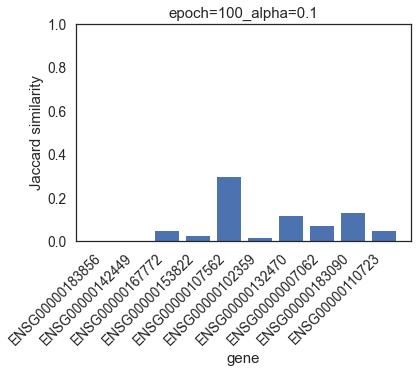

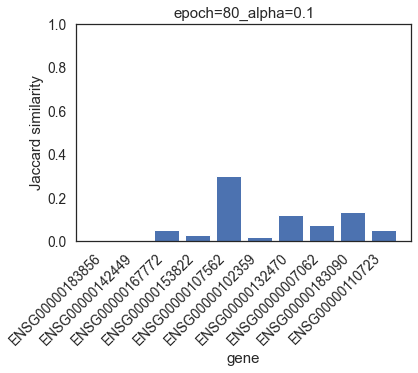

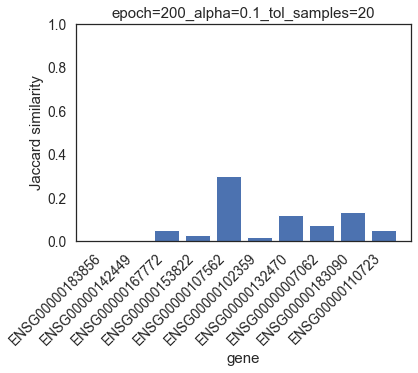

In [35]:
top_n_de = deseq.sort_values('abs_log2FC', ascending = False)['id'][10:20]
for emb, name in zip(emb_list, emb_names):
    get_closest_genes_jaccard(tom_df, emb, top_n_de, 50, name)

In [20]:
wgcna_modules = pd.read_csv(prefix+'/Shared drives/NIAAA_ASSIST/Data/eda_derived/wgcna_modules.csv')

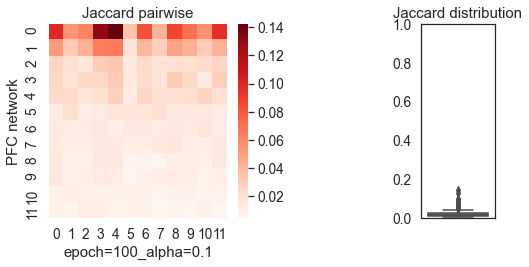

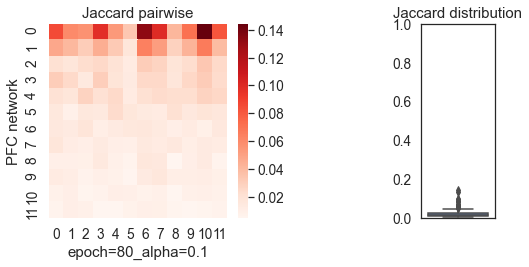

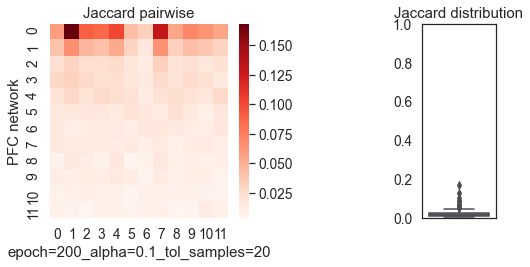

In [38]:
for kmeans, name in zip(kmeans_list, emb_names):
    cluster_jaccard_v2(wgcna_modules, kmeans, 'louvain_label', 'kmean_label', ['PFC network', name])

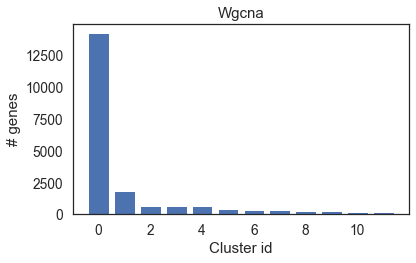

In [40]:
plot_gene_cnt_each_cluster([wgcna_modules], 'louvain_label', ['Wgcna'])

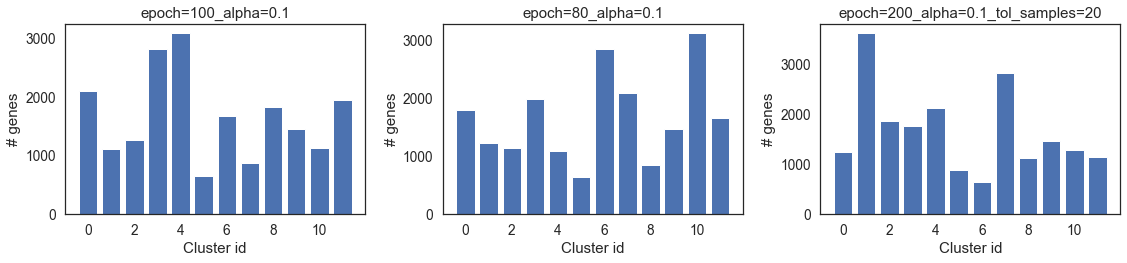

In [41]:
plot_gene_cnt_each_cluster(kmeans_list, 'kmean_label', emb_names)

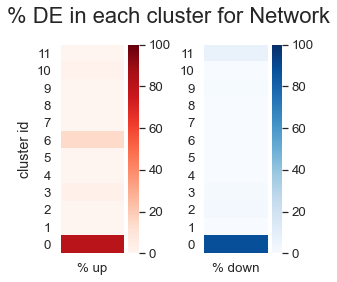

In [44]:
cluster_DE_perc(wgcna_modules, 'louvain_label', 'Network', deseq)

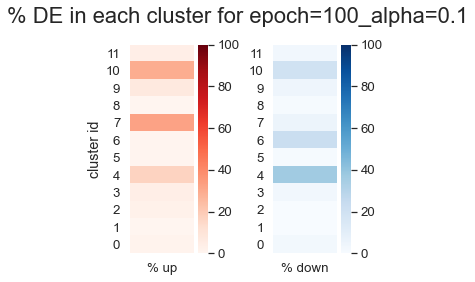

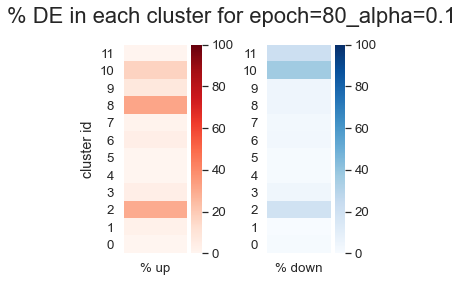

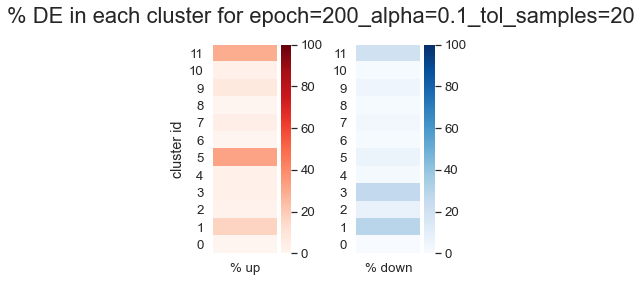

In [46]:
for kmeans, name in zip(kmeans_list, emb_names):
    cluster_DE_perc(kmeans, 'kmean_label', name, deseq)

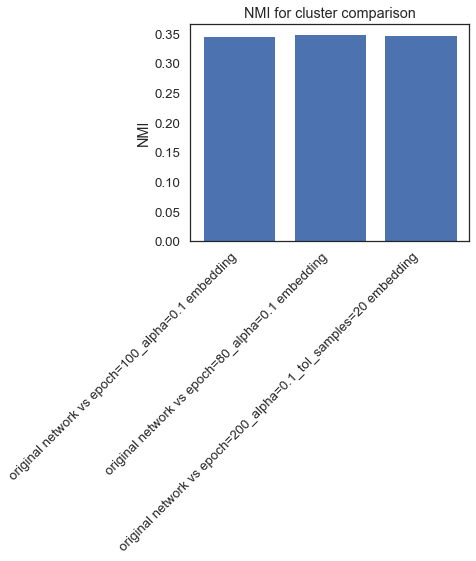

In [48]:
# for kmeans, name in zip(kmeans_list, emb_names):
network_comparison_names = ['original network' + f' vs {emb_names[i]} embedding' for i in range(len(emb_names))]
plot_cluster_nmi_comparison_v3('network', cluster1 = wgcna_modules, cluster1_column = 'louvain_label', 
                               cluster2_list= kmeans_list, cluster2_column = 'kmean_label', comparison_names = network_comparison_names)